In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pandas import Series, DataFrame

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import simpy
import shapely
import shapely.wkt

from shapely.geometry import Point
from shapely.geometry import MultiPoint, Polygon, MultiPolygon, LineString
from typing import Sequence

#expecting version 1.9
import pyproj 

In [3]:
import io
import requests
import shapely.geometry

## Table of contents
- Load velocity data Rijntakken
- Load network DTV\
1) Read nodes of DTV network\
2) Make a list of edges of Routes of the Rhine branches \
- Add correct geometry points to the velocity table\
3) Find closest edge from DTV network to velocity points\
4) Calculate for every edge the average velocity per flow rate at Lobith, according to the velocity data\
5) New re-organised dataframe\
6) Interpolate data\
7) Plot speed vs location\
8) Export data

### Load velocity data Rijntakken
The data has been obtained by simulations with WAQUA.The data consists of velocities at different locations in the Rhine branches, based on the flow rate at Lobith. The flow rates at Lobith are 1020m3/s, 2000m3/s, 2700m3/s, 4000m3/s, 4450m3/s, 6000m3/s, 8000m3/s, 10000m3/s, 12000m3/s and 16000m3/s.

In [4]:
from pathlib import Path
inputdir= Path('../input')

In [5]:
df_velocity_Rijntakken = pd.read_csv(inputdir /'rkm_join_allQ_20211015.csv')

In [6]:
df_velocity_Rijntakken

,X,Y,MODELKILOM,KENMERK,KILOMETER,Q1020,Q2000,Q2700,Q4000,Q4450,Q6000,Q8000,Q10000,Q12000,Q16000
0,212075,427009,854.00_BR,01 BR 854.00,854,1.11,1.34,1.47,1.58,1.60,1.66,1.76,1.90,2.03,2.25
1,211085,427120,855.00_BR,01 BR 855.00,855,1.13,1.39,1.54,1.62,1.70,1.85,1.87,1.94,2.06,2.32
2,210161,427485,856.00_BR,01 BR 856.00,856,1.24,1.46,1.60,1.64,1.69,1.85,1.85,1.85,1.92,2.07
3,209315,427994,857.00_BR,01 BR 857.00,857,1.04,1.28,1.50,1.59,1.65,1.84,1.87,1.89,1.88,1.97
4,208398,428422,858.00_BR,01 BR 858.00,858,1.01,1.26,1.43,1.63,1.69,1.86,1.99,2.07,2.08,2.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,191370,507713,995.00_IJ,06 IJ 995.00,995,0.25,0.46,0.55,0.71,0.89,1.03,1.31,1.54,1.77,2.08
343,190763,508500,996.00_IJ,06 IJ 996.00,996,0.22,0.40,0.49,0.64,0.83,0.98,1.23,1.44,1.64,2.07
344,189950,509067,997.00_IJ,06 IJ 997.00,997,0.22,0.41,0.49,0.64,0.83,0.96,1.22,1.49,1.73,2.23
345,189107,509572,998.00_IJ,06 IJ 998.00,998,0.21,0.39,0.48,0.63,0.79,0.93,1.19,1.45,1.67,2.13


### Load network DTV

The network of DTV will be loaded in this part. The network is based on FIS (Fairway Information Service).

In [7]:
G = nx.read_gpickle(inputdir / 'network_digital_twin_v0.2.pickle')

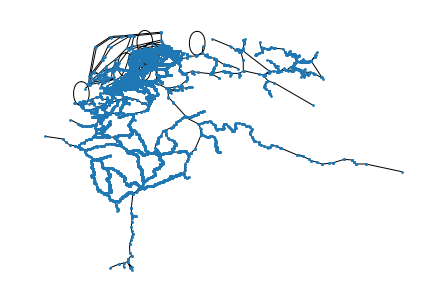

In [8]:
spatial_pos = {
    k: (v['X'], v['Y']) 
    for k, v 
    in G.nodes.items()
}
nx.draw(
    G, 
    pos=spatial_pos, 
    node_size=3
)

### 1)  Read nodes of DTV network

In [9]:
G.nodes.data('Wkt') #A location has an id number as well as latitude and logitude coordinates

NodeDataView({'8861219': 'POINT (5.6308690838450897 52.9447347262210997)', '8866461': 'POINT (5.6305963886121200 52.9438546215798027)', '8862212': 'POINT (6.0453320717063797 53.1087180987763006)', '8861581': 'POINT (6.0521727587013636 53.1160406391950346)', '8860954': 'POINT (4.4474078586978338 51.8818782583647931)', '8864050': 'POINT (4.4364019396941199 51.8805398055229006)', '8865802': 'POINT (4.4144399943498804 51.9093050135097656)', '8861605': 'POINT (4.4130212422254456 51.9111087813672043)', '8864258': 'POINT (4.3544383813870198 51.6615938492316005)', '8864774': 'POINT (4.2885870421420798 51.6502162851356985)', '8864595': 'POINT (4.6349137860731400 51.7935466805677507)', '8866901': 'POINT (4.6358326252144408 51.7922666558924973)', '8868015': 'POINT (5.6187971073933802 53.0105470488320023)', '8867749': 'POINT (5.6083279701705600 53.0085809362450036)', '8868009': 'POINT (5.1554437754252902 52.2989798224534965)', '8861301': 'POINT (5.1568443018783299 52.2984632108735994)', '8867997':

### 2) Make a list of edges of Routes of the Rhine branches 
The velocity data consists of locations (points) with velocity data in braches of the Rhine. To get an overview of the edges and nodes of the DTV network ,where the velocity data can be added to, 3 different routes will be made.

- Lobith - Ketelmeer (Rijn, Nederrijn, Ijssel)
- Lobith - Kinderdijk (Rijn, Nederrijn, Lek)
- Lobith - Werkendam (Rijn, Waal, Boven Merwede)

A dictionary is made for te the relevant locations along the river.

In [10]:
locaties = {
    'lobith': '8863233',
    'ketelmeer': '8863596',
    'kinderdijk': '8865140',
    'werkendam': '22638308',
    'griethausen': '8861160',
}

In [11]:
#data of one point in the DTV network
G.nodes[locaties['lobith']]  # Lobith

{'X': 6.04973476051681,
 'Y': 51.869881483353105,
 'geometry': {'type': 'Point',
  'coordinates': (6.04973476051681, 51.869881483353105)},
 'Wkt': 'POINT (6.0497347605168104 51.8698814833531046)'}

The shortest route is made between the begin location and the end location defined in the river. The route consists of nodes of the begin location, end location and of the locations in between.

In [12]:
#Netherlands
nodes_Waal = nx.shortest_path(G, locaties['lobith'], locaties['werkendam'])
nodes_Lek = nx.shortest_path(G, locaties['lobith'], locaties['kinderdijk'])
nodes_Ijssel = nx.shortest_path(G, locaties['lobith'], locaties['ketelmeer'])
#Germany
nodes_griethausen_germany = nx.shortest_path(G, locaties['griethausen'], \
                                             locaties['lobith'])

The different routes are put into one network, called Network_DTV. The Network_DTV consists of shapely files of the edges on the routes. The list can be used later for a function which couples velocity data to the DTV network.

In [13]:
Network_DTV = {}
for n_start, n_end in zip(nodes_Waal[:-1], nodes_Waal[1:]):
    e = G.edges[(n_start, n_end)]['Wkt']
    e = shapely.wkt.loads(e)
    Network_DTV[(n_start, n_end)] = e

for n_start, n_end in zip(nodes_Lek[:-1], nodes_Lek[1:]):
    e = G.edges[(n_start, n_end)]['Wkt']
    e = shapely.wkt.loads(e)
    Network_DTV[(n_start, n_end)] = e

for n_start, n_end in zip(nodes_Ijssel[:-1], nodes_Ijssel[1:]):
    e = G.edges[(n_start, n_end)]['Wkt']
    e = shapely.wkt.loads(e)
    Network_DTV[(n_start, n_end)] = e

for n_start, n_end in zip(nodes_griethausen_germany [:-1], nodes_griethausen_germany [1:]):
    e = G.edges[(n_start, n_end)]['Wkt']
    e = shapely.wkt.loads(e)
    Network_DTV[(n_start, n_end)] = e

### Add correct geometry points to the velocity table 
The coordinates of the velocity points, will be transformed to latitude and longitude values. These values are added to the velocity data. Thereafter, the values are made Points and aded to the velocity data column as well. The Points are used for the function, to couple data to the DTV network, which is applied later.

In [14]:
#transform coordinates
from pyproj import Proj, transform

inProj = Proj(init='epsg:28992')
outProj = Proj(init='epsg:4326')
x1,y1 = df_velocity_Rijntakken['X'].values,df_velocity_Rijntakken['Y'].values
lon,lat = transform(inProj,outProj,x1,y1)

The latitude and longitude values are added to the velocity data.

In [15]:
df_velocity_Rijntakken['lat'] = lat
df_velocity_Rijntakken['lon'] = lon

In [ ]:
# Plot velocity point with latitude and longitude coordinates, to check
plt.plot(lon, lat, 'k.');

In [ ]:
#show added column
df_velocity_Rijntakken[["X","Y","lat","lon"]]

The latitude and longitude values are added as a Point in the velocity_geomtery column in the velocity data.

In [18]:
df_velocity_Rijntakken['velocity_geometry'] = None
for index, row in df_velocity_Rijntakken.iterrows():
    df_velocity_Rijntakken.loc[index, 'velocity_geometry'] = Point(row['lon'], row['lat'])

In [19]:
#show columns of velocity data
df_velocity_Rijntakken.columns

Index(['X', 'Y', 'MODELKILOM', 'KENMERK', 'KILOMETER', 'Q1020', 'Q2000',
       'Q2700', 'Q4000', 'Q4450', 'Q6000', 'Q8000', 'Q10000', 'Q12000',
       'Q16000', 'lat', 'lon', 'velocity_geometry'],
      dtype='object')

In [20]:
#show geometry column vs velocities
df_velocity_Rijntakken[["Q1020", "Q2000",
                        "Q2700","Q4000",
                        "Q4450","Q6000",
                        "Q8000", "Q10000",
                        "Q12000","Q16000",
                        "velocity_geometry"]]

,Q1020,Q2000,Q2700,Q4000,Q4450,Q6000,Q8000,Q10000,Q12000,Q16000,velocity_geometry
0,1.11,1.34,1.47,1.58,1.60,1.66,1.76,1.90,2.03,2.25,POINT (6.215178782521452 51.82875786267671)
1,1.13,1.39,1.54,1.62,1.70,1.85,1.87,1.94,2.06,2.32,POINT (6.200836451963934 51.82985594808206)
2,1.24,1.46,1.60,1.64,1.69,1.85,1.85,1.85,1.92,2.07,POINT (6.187491381645783 51.83322861670847)
3,1.04,1.28,1.50,1.59,1.65,1.84,1.87,1.89,1.88,1.97,POINT (6.175298580422853 51.83788639847675)
4,1.01,1.26,1.43,1.63,1.69,1.86,1.99,2.07,2.08,2.18,POINT (6.162060517965848 51.84182172117956)
...,...,...,...,...,...,...,...,...,...,...,...
342,0.25,0.46,0.55,0.71,0.89,1.03,1.31,1.54,1.77,2.08,POINT (5.92348934127673 52.55582210150768)
343,0.22,0.40,0.49,0.64,0.83,0.98,1.23,1.44,1.64,2.07,POINT (5.914623961360235 52.5629348885688)
344,0.22,0.41,0.49,0.64,0.83,0.96,1.22,1.49,1.73,2.23,POINT (5.90269421692201 52.56808312547011)
345,0.21,0.39,0.48,0.63,0.79,0.93,1.19,1.45,1.67,2.13,POINT (5.890312807486501 52.57267485019488)


### 3) Find closest edge of DTV network to velocity points
In this part, the velocity data is added to the DTV network. For every velocity data point the closest edge from the DTV network is established with a funtion. The DTV network consists of routes defined at the beginning.

The function is defined.

In [21]:
def nearest_line(point: Point, lines: Sequence[LineString], keys: Sequence[tuple]) -> (int, float, tuple): 

    # For a point, find the nearest geometry from a list of points/lines
    #
    # point: Shapely Point
    # lines: List of shapely LineString
    # returns: index of nearest line, distance to nearest line
    d = np.full((len(lines)), fill_value=np.nan)
    for ii in range(len(lines)):
        d[ii] = point.distance(lines[ii])
    index = np.argmin(d)
    key = keys[index]
    return index, np.min(d), key

In [22]:
# test function with latitude and longitude values
nearest_line(Point(row['lon'], row['lat']), list(Network_DTV.values()), list(Network_DTV.keys()))

(131, 0.00014691497790417517, ('8864181', '8863442'))

Output of nearest-line function is saved in 3 lists. Output consists of index of nearest line (h),
distance to nearest line (j) and the id of the edge (edge_ids).

In [23]:
h = []
j = []
edge_ids = []
for index, p in df_velocity_Rijntakken['velocity_geometry'].items():
    k, i, key = nearest_line (p, list(Network_DTV.values()), list(Network_DTV.keys()))
    h.append(k)
    j.append(i)
    edge_ids.append(key)

The edge_id of the nearest edge, of the DTV network, to the velocity data point, is added to the velocity data.

In [24]:
df_velocity_Rijntakken['edge_id'] = edge_ids

In [25]:
# Add column with linestrings of the geometry values of edges of the DTV network, which corresponds with the velocity points.
df_velocity_Rijntakken['edge_geometry'] = df_velocity_Rijntakken['edge_id'].apply(lambda edge_id: Network_DTV[edge_id])

In [26]:
#Check if velocity_geometry and edge_geometry are close
df_velocity_Rijntakken[[
    "Q1020", "Q2000",
    "Q2700","Q4000",
    "Q4450","Q6000",
    "Q8000", "Q10000",
    "Q12000","Q16000",
    "velocity_geometry",
    "edge_id",
    "edge_geometry"]
]

,Q1020,Q2000,Q2700,Q4000,Q4450,Q6000,Q8000,Q10000,Q12000,Q16000,velocity_geometry,edge_id,edge_geometry
0,1.11,1.34,1.47,1.58,1.60,1.66,1.76,1.90,2.03,2.25,POINT (6.215178782521452 51.82875786267671),"(8861160, 28197693)","LINESTRING (6.17435950936821 51.8384885337535,..."
1,1.13,1.39,1.54,1.62,1.70,1.85,1.87,1.94,2.06,2.32,POINT (6.200836451963934 51.82985594808206),"(8861160, 28197693)","LINESTRING (6.17435950936821 51.8384885337535,..."
2,1.24,1.46,1.60,1.64,1.69,1.85,1.85,1.85,1.92,2.07,POINT (6.187491381645783 51.83322861670847),"(8861160, 28197693)","LINESTRING (6.17435950936821 51.8384885337535,..."
3,1.04,1.28,1.50,1.59,1.65,1.84,1.87,1.89,1.88,1.97,POINT (6.175298580422853 51.83788639847675),"(8861160, 28197693)","LINESTRING (6.17435950936821 51.8384885337535,..."
4,1.01,1.26,1.43,1.63,1.69,1.86,1.99,2.07,2.08,2.18,POINT (6.162060517965848 51.84182172117956),"(28197693, 8862687)","LINESTRING (6.16655400011307 51.8409340300914,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,0.25,0.46,0.55,0.71,0.89,1.03,1.31,1.54,1.77,2.08,POINT (5.92348934127673 52.55582210150768),"(B28180_B, B2727_A)",LINESTRING (5.931845429074186 52.5419652984849...
343,0.22,0.40,0.49,0.64,0.83,0.98,1.23,1.44,1.64,2.07,POINT (5.914623961360235 52.5629348885688),"(8866394, 8868191)","LINESTRING (5.91578376523263 52.5625368809135,..."
344,0.22,0.41,0.49,0.64,0.83,0.96,1.22,1.49,1.73,2.23,POINT (5.90269421692201 52.56808312547011),"(8866394, 8868191)","LINESTRING (5.91578376523263 52.5625368809135,..."
345,0.21,0.39,0.48,0.63,0.79,0.93,1.19,1.45,1.67,2.13,POINT (5.890312807486501 52.57267485019488),"(8868191, 8864181)","LINESTRING (5.89053405700101 52.5722509669625,..."


### 4) Calculate for every edge the average velocity per flow rate at Lobith, according to the velocity data

Re-organise velocity data table with rows per edge_id and columns of the 10 scenarios (10 flow rates at Lobith). Per edge_id, the corresponding velocity data is averaged.

In [27]:
edge_df = df_velocity_Rijntakken.groupby(['edge_id']).agg (
    Q1020  = ('Q1020','mean'), 
    Q2000  = ('Q2000','mean'), 
    Q2700  = ('Q2700','mean'), 
    Q4000  = ('Q4000','mean'), 
    Q4450  = ('Q4450','mean'), 
    Q6000  = ('Q6000','mean'), 
    Q8000  = ('Q8000','mean'), 
    Q10000 = ('Q10000','mean'),
    Q12000 = ('Q12000','mean'),
    Q16000 = ('Q16000','mean'),
    edge_geometry =('edge_geometry', 'first' )
)
edge_df

,Q1020,Q2000,Q2700,Q4000,Q4450,Q6000,Q8000,Q10000,Q12000,Q16000,edge_geometry
edge_id,,,,,,,,,,,
"(22638188, 8861687)",0.810,1.050,1.190000,1.410000,1.470000,1.730000,1.490000,1.520000,1.570000,1.600000,"LINESTRING (5.8340360338013 51.8619155348306, ..."
"(22638200, 28197686)",0.795,1.135,1.300000,1.535000,1.600000,1.805000,2.045000,2.275000,2.510000,2.875000,"LINESTRING (6.08125297602789 51.8574882425024,..."
"(28197686, 8863233)",0.770,1.090,1.290000,1.530000,1.590000,1.780000,1.980000,2.130000,2.280000,2.530000,"LINESTRING (6.06349789502451 51.8654549324066,..."
"(28197693, 8862687)",0.948,1.228,1.402000,1.602000,1.670000,1.852000,1.998000,1.994000,1.942000,2.044000,"LINESTRING (6.16655400011307 51.8409340300914,..."
"(8860617, 8865603)",0.020,0.200,0.416667,0.658889,0.723333,0.908889,1.128889,1.345556,1.467778,1.675556,"LINESTRING (4.96658774632189 51.9596789891622,..."
...,...,...,...,...,...,...,...,...,...,...,...
"(B8661453_B, 22638188)",0.830,1.060,1.170000,1.340000,1.390000,1.280000,1.340000,1.470000,1.580000,1.760000,LINESTRING (5.841085217675227 51.8581606798987...
"(B8833_B, 8862813)",0.040,0.310,0.620000,0.920000,0.990000,1.160000,1.230000,1.200000,1.080000,1.080000,LINESTRING (5.114415772782015 52.0015574049922...
"(B9697_B, 8867516)",0.620,0.770,0.820000,0.830000,0.830000,0.800000,0.770000,0.790000,0.820000,0.700000,LINESTRING (6.166076730625829 52.2312155842514...


### 5) New re-organised dataframe
A new new table is made. With columns for the edge_id, edge_geometry, scenario and corresponding velocity.

In [28]:
#unpivot table to scenarios and velocity values. To easily select by scenario.
scenario_edge_df = pd.melt(
    edge_df, 
    id_vars=['edge_geometry'], 
    value_vars=['Q1020', 'Q2000',
                'Q2700','Q4000',
                'Q4450','Q6000',
                'Q8000', 'Q10000',
                'Q12000','Q16000'], 
    var_name='scenario', 
    value_name='velocity',
    ignore_index=False
)

In [29]:
#Set column edge_geometry as active geometry column df --> gdf
scenario_edge_gdf = scenario_edge_df.rename(columns = {'geometry': 'edge_geometry'}).set_geometry('edge_geometry')

In [ ]:
#plot edge with velocity data
scenario_edge_gdf.plot();

In [ ]:
#show scenario Q2000
scenario_edge_gdf.query("scenario == 'Q2000' ")

### 6) Interpolate data

#### Check network
Compare the velocity edges with the full network

In [ ]:
# check that all edges are pressent
edges = [G.edges[idx] for idx in scenario_edge_gdf.index]

In [ ]:
# list all nodes in the velocities data frame
nodes = []
for e in scenario_edge_gdf.index:
    nodes.extend(e)
nodes = set(nodes)

# create a subgraph of only the data with velocities
G_velocities = G.subgraph(nodes)

In [ ]:
# this should show some gaps
#fig, ax = plt.subplots()
#nx.draw(G_velocities, ax=ax)
# count the number of cliques, even without cliques some edges maybe missing
nx.clique.graph_clique_number(G)

#### Find edges without velocities
We can use several approaches for the missing edges. We could loop over edges of main routes and remember the last velocity and the next velocity and fill it in. Here we are looking from the edges that are missing. From those missing edges we will search left and right until we have 2 velocities.

We will first define the boundary nodes of the routes where we expect edges to be filled with velocities.

In [ ]:
boundary_nodes = {
    "slikkerveer": "8865140",
    "werkendam": '22638029',
    "emmerich": '8861160',
    "ketelhaven": '8863596'
}

Now determine the routes, based on the boundary nodes, by finding the shortest paths.

In [ ]:
# origin destination diagrams
ods = [
    [boundary_nodes['slikkerveer'], boundary_nodes['emmerich']],
    [boundary_nodes['werkendam'], boundary_nodes['emmerich']],
    [boundary_nodes['ketelhaven'], boundary_nodes['emmerich']]
]

Based on these origin destination paths, keep track of all the nodes

In [ ]:
# lookup all nodes that are in one of our routes of interest
od_paths = []
for od in ods:
    od_path = nx.shortest_path(G, od[0], od[1])
    od_paths.extend(od_path)

Now we can create a new subgraph with only the nodes that we are interested in.

In [ ]:
G_boundaries = G.subgraph(od_paths)

In [ ]:
nx.draw(G_boundaries)

In [ ]:
# Compute the positions to render for the graph
pos = {}
for n in G_boundaries.nodes:
    node = G_boundaries.nodes[n]
    pos[n] = (node['X'], node['Y'])

In [ ]:
# plot the subgraph with only the relevant parts
nx.draw(G_boundaries, pos)

#### Search missing edges
Now that we know which edges we want velocities. We can lookup the ones that we have velocities. The ones remaining are the missings.

We use e to refer to an edge id (tuple of node ids) and e_r as the reversed version of that edge id.

In [ ]:
missing_edges = []
for e in G_boundaries.edges:
    edge = G_boundaries.edges[e]
    e_r = tuple(reversed(e))
    
    # is e in our list of ids
    has_e = e in scenario_edge_gdf.index
    # is e reversed in our list
    has_e_r = e_r in scenario_edge_gdf.index
    # either one, we already have a velocity
    if has_e or has_e_r:
        continue
        
    # if we did not find our edge it is missing and needs interpolation
    missing_edges.append(e)

In [ ]:
# how many edges are we missing
len(missing_edges)

In [ ]:
# print one example
missing_edge = missing_edges[0]
missing_edge

### Depth first search back and forth
Now for the main logic. Look left down the graph, using depth first predessors. Look right down the graph, using successors. Keep track of the velocities that we find.

In [ ]:
def find_velocities(missing_edge):
    """find nearest velocities left and right of this edge"""
    
    left_velocity = None
    prev_n = missing_edge[0]
    for n in nx.dfs_predecessors(G, missing_edge[0]):

        # edge
        e = (prev_n, n)

        # reversed edge
        e_r = (n, prev_n)

        # do we have a velocity in this edge
        has_e = e in scenario_edge_gdf.index
        if has_e:
            # use a list of 1 tuple so it does not think it should unpack it
            left_velocity = scenario_edge_gdf.loc[[e]]
            break
        
        has_e_r = e_r in scenario_edge_gdf.index
        if has_e_r:
            # use a list of 1 tuple so it does not think it should unpack it

            left_velocity = scenario_edge_gdf.loc[[e_r]]
            break
        prev_n = n
        
        
    right_velocity = None
    prev_n = missing_edge[1]
    for n in nx.dfs_successors(G, missing_edge[1]):

        # edge
        e = (prev_n, n)

        # reversed edge
        e_r = (n, prev_n)

        # do we have a velocity in this edge
        has_e = e in scenario_edge_gdf.index
        if has_e:
            # use a list of 1 tuple so it does not think it should unpack it
            right_velocity = scenario_edge_gdf.loc[[e]]
            break
        
        has_e_r = e_r in scenario_edge_gdf.index
        if has_e_r:
            # use a list of 1 tuple so it does not think it should unpack it

            right_velocity = scenario_edge_gdf.loc[[e_r]]
            break
        prev_n = n
        

    return left_velocity, right_velocity

### Merge datasets and interpolate
Here we lookup the left and right branch velocities.

In [ ]:
missing_dfs = []
for missing_edge in missing_edges:
    left_velocities, right_velocities = find_velocities(missing_edge)
    # merge left and right dataframe (by scenario)
    interpolate_df = pd.merge(
        left_velocities.reset_index(), 
        right_velocities.reset_index(), 
        left_on='scenario', 
        right_on='scenario',
        suffixes=['_left', '_right']
    )
    # add edge id
    interpolate_df['id'] = [missing_edge for i in range(interpolate_df.shape[0])]
    # compute average velocity per scenario
    interpolate_df['velocity'] = (interpolate_df['velocity_left'] + interpolate_df['velocity_right']) / 2
    # lookup our geometry
    geometry = G.edges[missing_edge]['geometry']
    # convert it to shapely object
    geometry = shapely.geometry.asShape(geometry)
    # add it to all rows
    interpolate_df['geometry'] = [geometry for i in range(interpolate_df.shape[0])]
    # append to the list
    missing_dfs.append(
        interpolate_df[['id', 'scenario', 'geometry', 'velocity']]

In [ ]:
# merge all dataframes
velocities_interpolated_df = pd.concat(
    missing_dfs + [scenario_edge_gdf.reset_index()]
).set_index('id')

In [ ]:
velocities_interpolated_df

In [ ]:
# check if it looks good...
velocities_interpolated_df.query("scenario == 'Q2000'").plot(column='velocity', label='velocity')
plt.legend(loc='upper left')

### 7) Plot speed vs location

Plot data per scenario.

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q1020')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q1020' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=[True],
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q2000 ')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q2000' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=True,
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q2700')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q2700' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=True,
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q4000')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q4000' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=True,
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q4450')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q4450' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=True,
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q6000')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q6000' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=True,
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q8000')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q8000' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=True,
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q10000')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q10000' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=True,
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q12000')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q12000' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=True,
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,12)) 
ax.set_title('Velocity Data in m/s in Rhine Branches, Scenario: Q16000')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

gdf = scenario_edge_gdf.query("scenario == 'Q16000' ")
gdf.plot(column='velocity',
         ax=ax, 
         legend=True,
         legend_kwds={'loc':'upper left'},
         cmap='viridis',
         scheme='quantiles'
        )

plt.show()

### 8) Export data